In [348]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve

# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from collections import namedtuple

from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [87]:
df = pd.read_csv("./data/dados_voz_genero.csv")

# IA048 ‚Äì Aprendizado de M√°quina
## Exerc√≠cios de Fixa√ß√£o de Conceitos (EFC) 2 ‚Äì 2s2020
###  Classifica√ß√£o bin√°ria

Voc√™ disp√µe de um conjunto de dados contendo 3168 amostras rotuladas. Cada amostra √© descrita por 19 atributos ac√∫sticos extra√≠dos de trechos gravados de voz, considerando a faixa de frequ√™ncias de 0 a 280 Hz. A √∫ltima coluna corresponde ao r√≥tulo associado a cada padr√£o, sendo igual a ‚Äò1‚Äô para o g√™nero masculino, e ‚Äò0‚Äô para o g√™nero feminino.

  a. Fa√ßa uma an√°lise das caracter√≠sticas dos atributos de entrada considerando os respectivos histogramas e as medidas de correla√ß√£o entre eles.
  
  b. Construa, ent√£o, o modelo de regress√£o log√≠stica para realizar a classifica√ß√£o dos padr√µes. Para isso, reserve uma parte dos dados (e.g., 20%) para valida√ß√£o, usando todas as demais amostras para o treinamento do modelo. Pensem na pertin√™ncia e na possibilidade de realizar algum pr√©-processamento nos dados (e.g., normaliza√ß√£o).

  Apresente e discuta os seguintes resultados com rela√ß√£o ao conjunto de valida√ß√£o:

    - A curva ROC;
    - A curva de evolu√ß√£o da ùêπ -medida em fun√ß√£o do threshold de decis√£o

  c. Indique qual seria o valor mais adequado para o threshold de decis√£o e por qu√™. Empregando, ent√£o, esse threshold, obtenha a matriz de confus√£o e a acur√°cia do classificador para o conjunto de valida√ß√£o. Comente os resultados obtidos.

In [349]:
def t_test(a, b):
    N = len(a)
    #For unbiased max likelihood estimate we have to divide the var by N-1, and therefore the parameter ddof = 1
    var_a = a.var(ddof=1)
    var_b = b.var(ddof=1)

    #std deviation
    s = np.sqrt((var_a + var_b)/2)

    ## Calculate the t-statistics
    t = (a.mean() - b.mean())/(s*np.sqrt(2/N))

    ## Compare with the critical t-value
    #Degrees of freedom
    df = 2*N - 2

    #p-value after comparison with the t 
    p = 1 - stats.t.cdf(t,df=df)
    return p

def histogram_intersection(a, b):
    return t_test(a, b)

def plot_histogram(df, column='dfrange'):    
    mapping = { 0: 'Female', 1: 'Male' }
    figure = plt.figure(figsize=(24, 24))
    seaborn.histplot(df.replace({ 'label': mapping }), x=column, alpha=0.5, hue='label')
    return abs(1 - t_test(df[df['label'] == 1][column], df[df['label'] == 0][column]))

def plot_matrix(df):
    correlation = df.corr().abs()
    np.fill_diagonal(correlation.values, 0)

    figure = plt.figure(figsize=(24, 24))
    plt.matshow(correlation, fignum=figure.number)

    xticks = plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
    yticks = plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
    colorbar = plt.colorbar()

    serie = correlation.unstack().sort_values(ascending=False, kind="quicksort")
    highest_correlations = serie.drop_duplicates().where(serie > 0.8).dropna()

    return highest_correlations


Score(none=0.5, logistic_regression=0.9835209612161285)


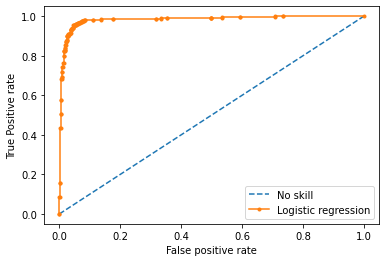

Score(none=0.5, logistic_regression=0.9835209612161285)

In [343]:
def logistic_regression(df, test_size=0.2):
    model = LogisticRegression()
    X = df[['meanfun']]
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    model.fit(X_train, y_train)

    return model.score(X_test, y_test)

def roc_score(df):
    X = df[['meanfun']]
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)
    ns_probs = [0 for _ in range(len(y_test))]
    model = LogisticRegression(solver='lbfgs')
    model.fit(X_train, y_train)

    lr_probs = model.predict_proba(X_test)
    lr_probs = lr_probs[:, 1]
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = roc_auc_score(testy, lr_probs)
    Score = namedtuple('Score', ['none', 'logistic_regression'])

    return Score(ns_auc, lr_auc)

def roc_plot(df):
    X = df[['meanfun']]
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)
    
    model = LogisticRegression(solver='lbfgs')
    model.fit(X_train, y_train)

    ns_probs = [0 for _ in range(len(y_test))]
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

    lr_probs = model.predict_proba(X_test)
    lr_probs = lr_probs[:, 1]
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic regression')
    plt.xlabel('False positive rate')
    plt.ylabel('True Positive rate')    
    plt.legend()
    plt.show()

    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    Score = namedtuple('Score', ['none', 'logistic_regression'])

    return Score(ns_auc, lr_auc)

print(roc_score(df))
roc_plot(df)


maxdom    dfrange     0.999838
kurt      skew        0.977020
centroid  median      0.925445
Q25       centroid    0.911416
sd        IQR         0.874660
IQR       Q25         0.874189
sfm       sp.ent      0.866411
sd        Q25         0.846931
sfm       sd          0.838086
label     meanfun     0.833921
meandom   maxdom      0.812838
          dfrange     0.811304
dtype: float64

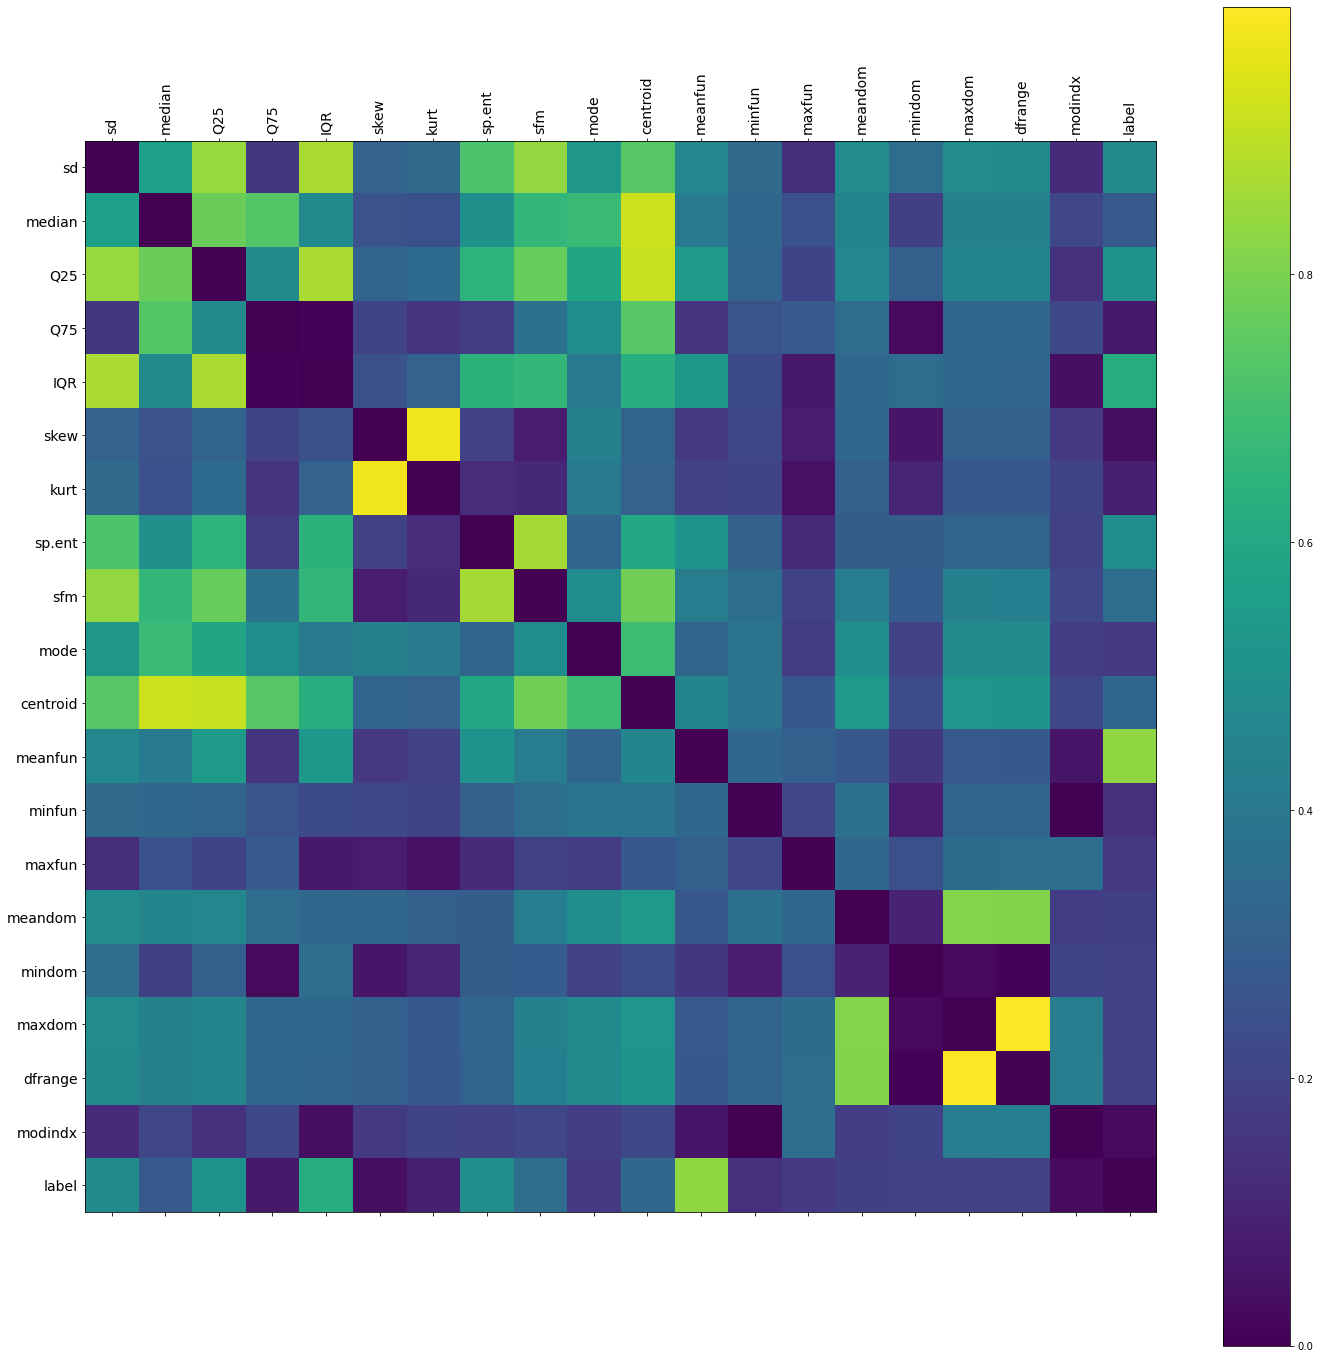

In [251]:
plot_matrix(df)

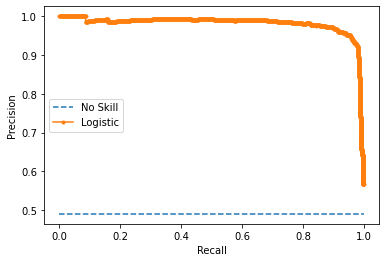

Logistic(f1=0.9431396786155747, auc=0.9811288957722084)


In [347]:
def precision(df):
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
    model = LogisticRegression(solver='lbfgs')
    model.fit(trainX, trainy)

    lr_probs = model.predict_proba(testX)
    lr_probs = lr_probs[:, 1]
    yhat = model.predict(testX)
    lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
    lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)

    no_skill = len(testy[testy==1]) / len(testy)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

    Logistic = namedtuple('Logistic', ['f1', 'auc'])
    return Logistic(lr_f1, lr_auc)

print(precision(df))

1.0


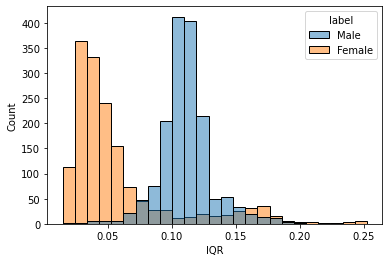

In [252]:
print(plot_histogram(df, column='IQR'))

<AxesSubplot:xlabel='Q25', ylabel='Count'>

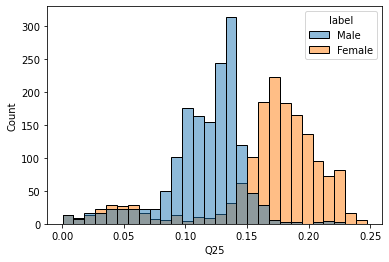

In [239]:
plot_histogram(df, column='Q25')

0.0

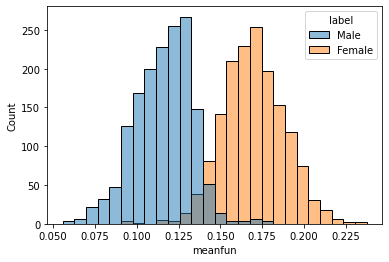

In [256]:
plot_histogram(df, column='meanfun')

1.0

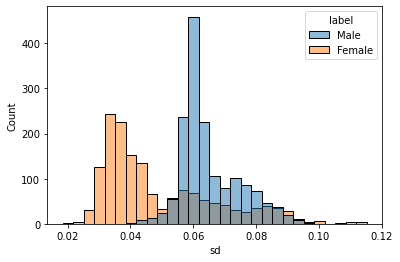

In [257]:
plot_histogram(df, column='sd')

plot_histogram(df, column='sp.ent')

###  Classifica√ß√£o multi-classe

Problema: identifica√ß√£o de atividade humana usando dados de smartphones

Base de dados: [har_smartphone.zip](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones)

Nesta atividade, o conjunto de dados cont√©m atributos nos dom√≠nios do tempo e da frequ√™ncia extra√≠dos de sinais de aceler√¥metro e girosc√≥pio de um smartphone. Os r√≥tulos das amostras indicam qual a atividade realizada por um volunt√°rio humano durante a aquisi√ß√£o dos sinais:

| Label | Activity         |
|-------|------------------|
| 0     | Caminhada        |
| 1     | Subindo escadas  |
| 2     | Descendo escadas |
| 3     | Sentado          |
| 4     | Em p√©            |
| 5     | Deitado          |

O conjunto de dados j√° est√° separado em uma parte para treinamento e outra para teste. Ao todo, temos 7352 amostras de treinamento e 2947 amostras de teste; cada amostra √© descrita por 561 atributos temporais ou espectrais.
Dois m√©todos de classifica√ß√£o ser√£o explorados nesta aplica√ß√£o: regress√£o log√≠stica e ùëò-nearest neighbors.

  a. Construa uma solu√ß√£o para este problema baseada no modelo de regress√£o log√≠stica. Descreva a abordagem escolhida para resolv√™-lo (softmax, classificadores bin√°rios combinados em um esquema um-contra-um ou um- contra-todos). Obtenha, ent√£o, a matriz de confus√£o para o classificador considerando os dados do conjunto de teste.
Al√©m disso, adote uma m√©trica global para a avalia√ß√£o do desempenho (m√©dio) deste classificador. Como sugest√£o, consulte a refer√™ncia [M. SOKOLOVA & G. LAPALME, ‚ÄúA Systematic Analysis of Performance Measures for Classification Tasks‚Äù. Information Processing & Management, vol. 45, no. 4, pp. 427-437, 2009](https://www.researchgate.net/publication/222674734_A_systematic_analysis_of_performance_measures_for_classification_tasks). Discuta os resultados obtidos.

  b. Considere, agora, a t√©cnica ùëò-nearest neighbors (ùëòNN). Varie o par√¢metro ùëò e
analise as matrizes de confus√£o obtidas junto aos dados de teste e o desempenho m√©dio (computado com a mesma m√©trica adotada no item (a)). Comente os resultados obtidos, inclusive estabelecendo uma compara√ß√£o com o desempenho da regress√£o log√≠stica.

In [471]:
def roc_score(X_train, X_test, y_train, y_test):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)
    ns_probs = [0 for _ in range(len(y_test))]
    model = LogisticRegression(solver='lbfgs')
    model.fit(X_train, y_train)

    lr_probs = model.predict_proba(X_test)
    lr_probs = lr_probs[:, 1]
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = roc_auc_score(testy, lr_probs)
    Score = namedtuple('Score', ['none', 'logistic_regression'])

    return Score(ns_auc, lr_auc)

def logistic_regression(df, test_size=0.2):
    model = LogisticRegression()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    model.fit(X_train, y_train)

    return model.score(X_test, y_test)

def trans():
    f = open('./data/har_smartphone/X_train.csv')
    for d in f.readlines():
        print(d)
    f.close()

def logistic_regression():
    X_train = pd.read_csv('./data/har_smartphone/X_train.csv', sep=' ', names=list('012345'))
    print(X_train.head())
    print(len(X_train))
print(logistic_regression())

In [460]:
foo()

FileNotFoundError: [Errno 2] No such file or directory: './data/har_smartphone/X_train.txt'